# Imports

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import time

# Image Augmentation

## Common image augmentation methods

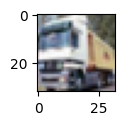

In [2]:
plt.figure(figsize=(1, 2))
dataset = torchvision.datasets.CIFAR10(root="data", download=True)
#print one image from the dataset
image, label = dataset[1]
plt.imshow(image)

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    fig = plt.figure(figsize=(num_cols * scale, num_rows * scale))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(Y[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Flipping and cropping

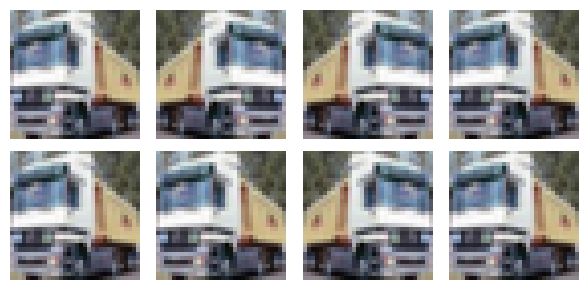

In [4]:
apply(image, torchvision.transforms.RandomHorizontalFlip())

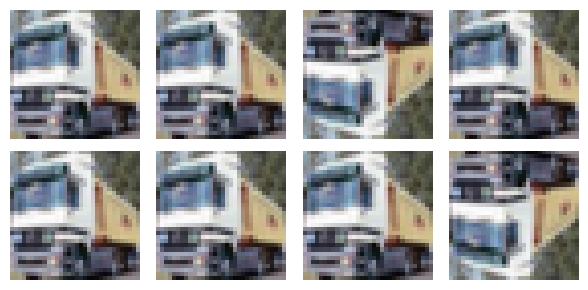

In [5]:
apply(image, torchvision.transforms.RandomVerticalFlip())

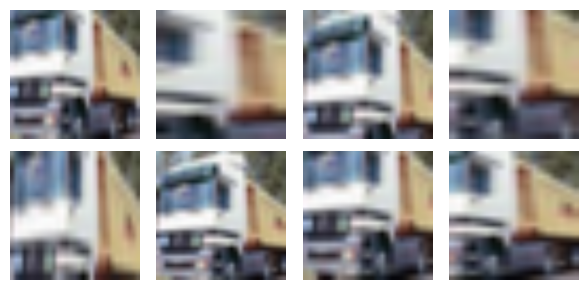

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(image, shape_aug)

### Changing colors

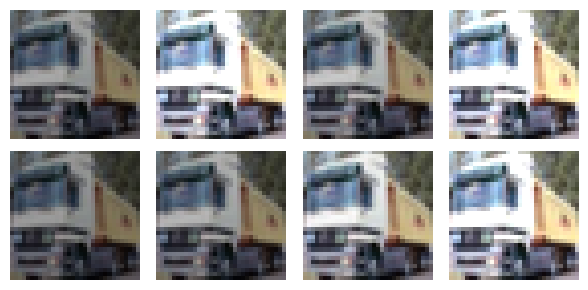

In [7]:
apply(image, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

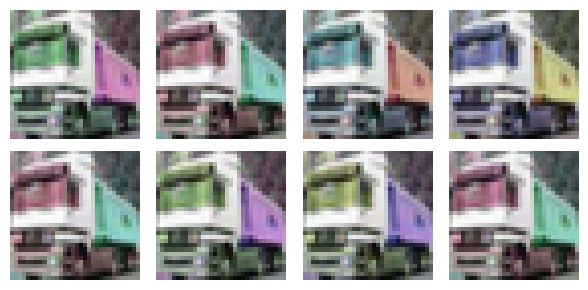

In [8]:
apply(image, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

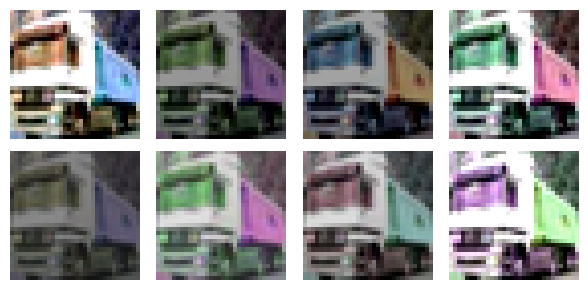

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(image, color_aug)

### Combining augmentation methods

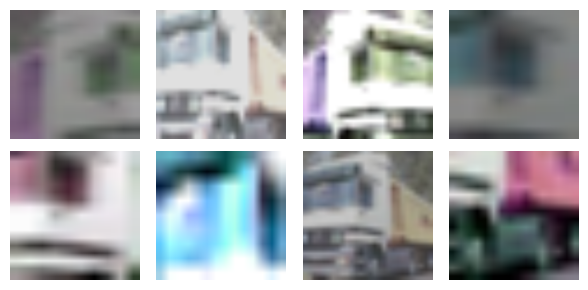

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(image, augs)

## Training with image augmentation

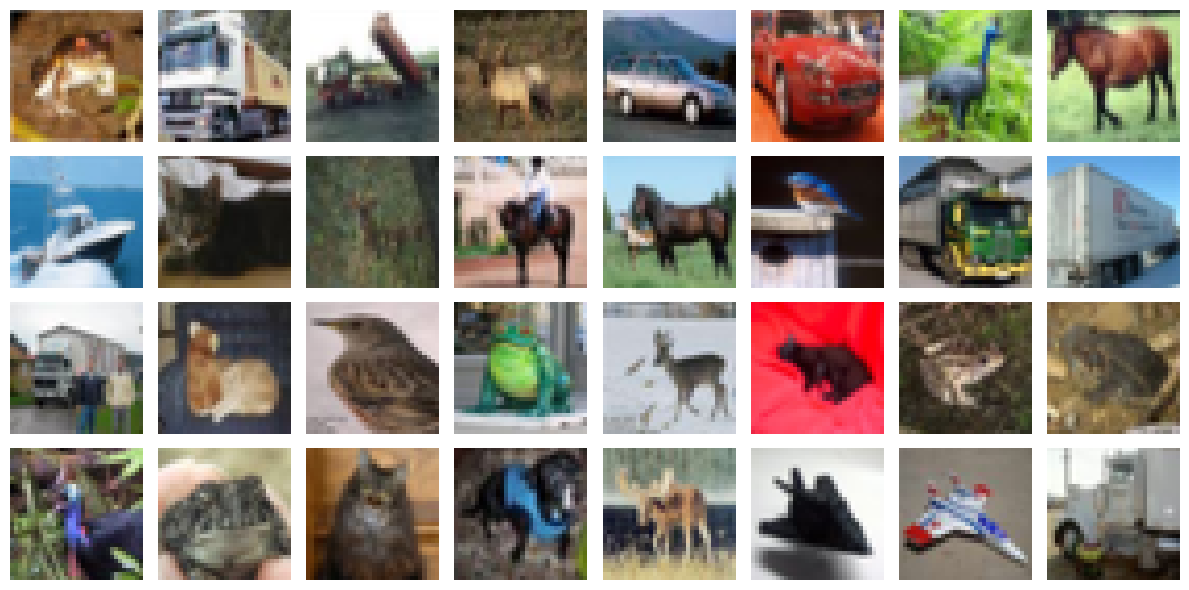

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="data",
                                          download=True)
# Create a figure with the specified size
plt.figure(figsize=(12, 6))
# Display 32 images in a 4x8 grid
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(all_images[i][0])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=4)
    return dataloader

## Multi-GPU training

In [14]:
class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

class Animator:  # Define a new Animator class that properly handles None values
	def __init__(self, xlabel=None, ylabel=None, legend=None):
		self.data = {'train_loss': [], 'train_acc': [], 'test_acc': []}
		self.epochs = []
		
	def add(self, epoch, metrics):
		self.epochs.append(epoch)
		train_loss, train_acc, test_acc = metrics
		if train_loss is not None:
			self.data['train_loss'].append(float(train_loss))
		if train_acc is not None:
			self.data['train_acc'].append(float(train_acc))
		if test_acc is not None:
			self.data['test_acc'].append(float(test_acc))
			
	def show(self):
		plt.figure(figsize=(10, 6))
		for label, values in self.data.items():
			if values:  # Only plot if we have data
				plt.plot(self.epochs[:len(values)], values, label=label)
		plt.xlabel('Epoch')
		plt.ylabel('Metric Value')
		plt.legend()
		plt.grid(True)
		plt.show()

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.to(y.dtype) == y
    return float(cmp.sum())

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

In [15]:

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices):
    """Train a model with multiple GPUs."""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator()  # Using the custom Animator implementation
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    for epoch in range(num_epochs):
        metric = Accumulator(4)  # Using the custom Accumulator
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss = metric[0] / metric[2]
                train_acc = metric[1] / metric[3]
                animator.add(epoch + (i + 1) / num_batches, 
                           (train_loss, train_acc, None))
        
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'Loss: {metric[0] / metric[2]:.3f}')
    print(f'Train accuracy: {metric[1] / metric[3]:.3f}')
    print(f'Test accuracy: {test_acc:.3f}')
    print(f'Training speed: {metric[2] * num_epochs / timer.sum():.1f} examples/sec')
    print(f'Device(s) used: {str(devices)}')
    
    animator.show()  # Display the training curves

In [16]:
devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]

def resnet18(num_classes, in_channels=3):
    """Construct a ResNet-18 model."""
    net = torchvision.models.resnet18(weights=None)
    if in_channels != 3:
        net.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    return net

def init_cnn(module):
    """Initialize weights of Conv2D and Linear layers."""
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(module.weight)

In [17]:
batch_size, devices, net = 256, devices, resnet18(10, 3)
net.apply(init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

C:\Users\Ishaan\AppData\Local\Temp\ipykernel_18468\3082397923.py:70: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


Loss: 0.443
Train accuracy: 0.844
Test accuracy: 0.665
Training speed: 12766.3 examples/sec
Device(s) used: [device(type='cuda', index=0)]


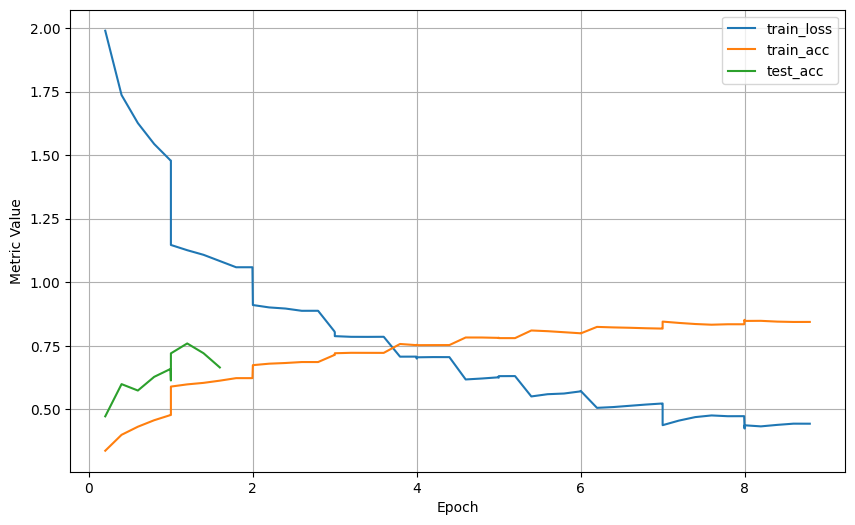

In [18]:
train_with_data_aug(train_augs, test_augs, net)

# Fine-Tuning

## Transfer Learning

In [19]:
dataset_loc = "data/hotdog/hotdog"
train_imgs = torchvision.datasets.ImageFolder(root=dataset_loc + "/train", transform=train_augs)
test_imgs = torchvision.datasets.ImageFolder(root=dataset_loc + "/test", transform=test_augs)

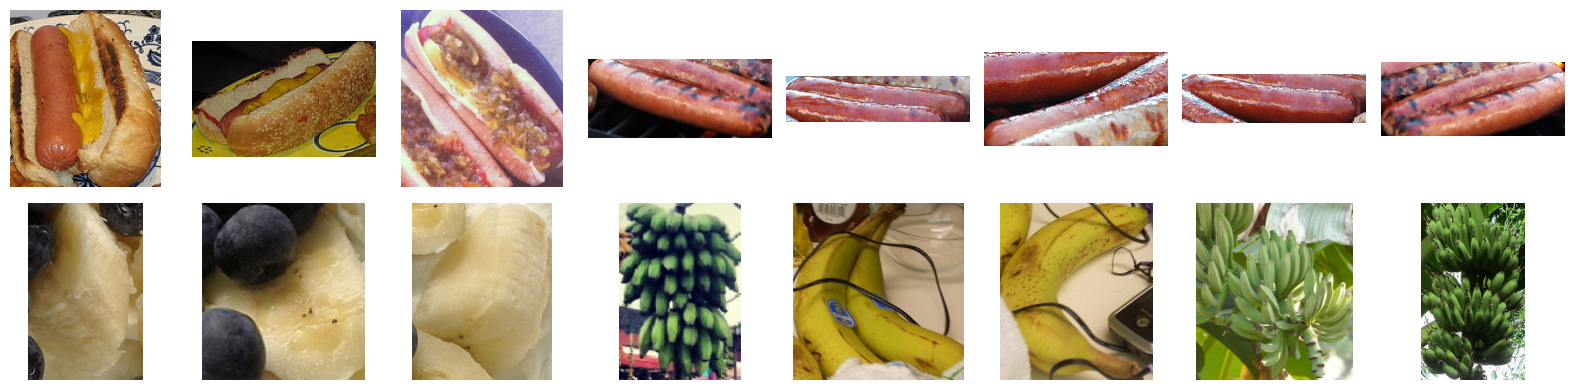

In [20]:
plt.figure(figsize=(16, 4))
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(torchvision.transforms.ToPILImage()(hotdogs[i]))
    plt.axis('off')
    plt.subplot(2, 8, i + 9)
    plt.imshow(torchvision.transforms.ToPILImage()(not_hotdogs[i]))
    plt.axis('off')
plt.tight_layout()

In [21]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### Defining and initializing the model

In [22]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [24]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0825,  0.1011, -0.0071,  ...,  0.0771, -0.0085,  0.0943],
        [-0.0100,  0.0205, -0.0127,  ...,  0.0285, -0.0257, -0.0737]],
       requires_grad=True)

### Fine-tuning the model

In [25]:
import os
devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(dataset_loc, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(dataset_loc, 'test'), transform=test_augs),
        batch_size=batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

Loss: 0.161
Train accuracy: 0.939
Test accuracy: 0.920
Training speed: 1081.8 examples/sec
Device(s) used: [device(type='cuda', index=0)]


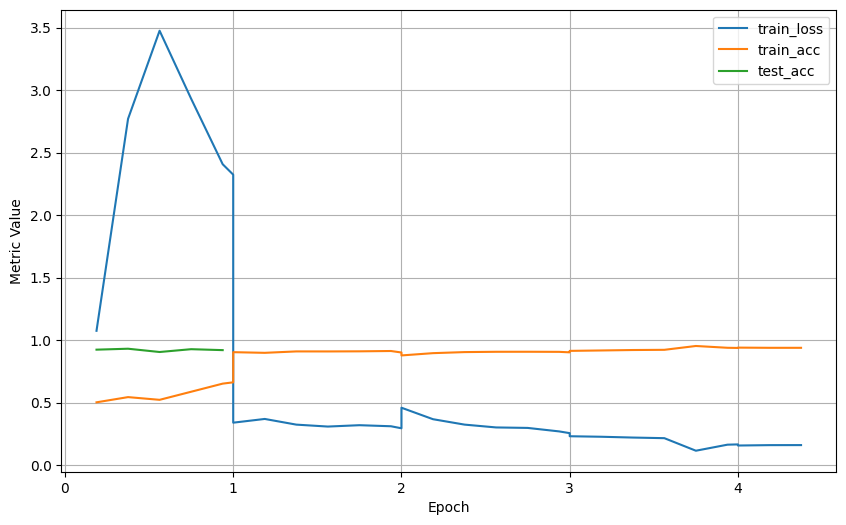

In [26]:
train_fine_tuning(finetune_net, 5e-5)

Loss: 0.351
Train accuracy: 0.855
Test accuracy: 0.839
Training speed: 1080.1 examples/sec
Device(s) used: [device(type='cuda', index=0)]


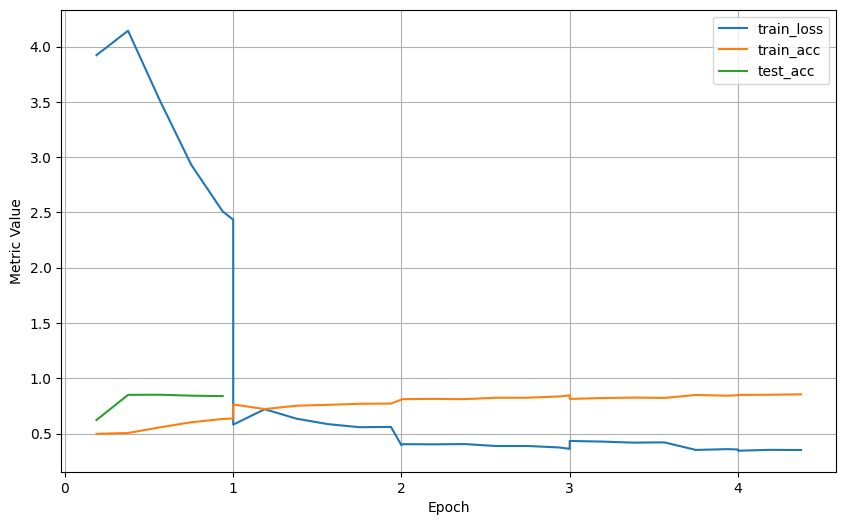

In [27]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

The fine-tuned model seems to perform better for the same epoch because it's inital parameters are more effective

## Bounding Boxes

In [28]:
def box_corner_to_center(boxes):
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    #Center x is the midpoint of x1 and x2
    cx = (x1 + x2) / 2
    #Center y is the midpoint of y1 and y2
    xy = (y1 + y2) / 2
    #Calculate width and height
    w = x2 - x1
    h = y2 - y1
    return torch.stack((cx, xy, w, h), axis=-1)

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    #x1 is the left edge
    x1 = cx - 0.5 * w
    #y1 is the top edge
    y1 = cy - 0.5 * h
    #x2 is the right edge
    x2 = cx + 0.5 * w
    #y2 is the bottom edge
    y2 = cy + 0.5 * h
    return torch.stack((x1, y1, x2, y2), axis=-1)

In [29]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

Adding the bounding boxes for cat and dog from image manually and checking if the conversion from bounding box to center and back to bounding box is valid

In [30]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [31]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
        fill=False, edgecolor=color, linewidth=2)

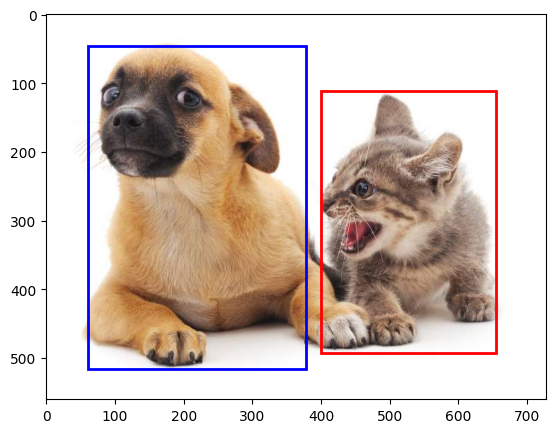

In [32]:
fig = plt.figure(figsize=(8, 5))
img = plt.imread('data/catdog.jpg')
plt.imshow(img)
#Adding the bounding boxes for cat and dog in the figure
plt.gca().add_patch(bbox_to_rect(dog_bbox, 'blue'))
plt.gca().add_patch(bbox_to_rect(cat_bbox, 'red'))

### Generating multiple anchor boxes

In [33]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [34]:
img = torchvision.io.read_image("data/catdog.jpg")
h, w = img.shape[-2:]

print(h, w)

561 728


In [35]:
X = torch.rand(size=(1, 3, h, w))
# Convert sizes and ratios to tensors for proper calculation
sizes = torch.tensor([0.75, 0.5, 0.25])
ratios = torch.tensor([1, 2, 0.5])
Y = multibox_prior(X, sizes, ratios)
print(Y.shape) 

torch.Size([1, 2042040, 4])


C:\Users\Ishaan\AppData\Local\Temp\ipykernel_18468\3993678249.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  size_tensor = torch.tensor(sizes, device=device)
C:\Users\Ishaan\AppData\Local\Temp\ipykernel_18468\3993678249.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ratio_tensor = torch.tensor(ratios, device=device)


In [36]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.0551, 0.0715, 0.6331, 0.8215])

In [37]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

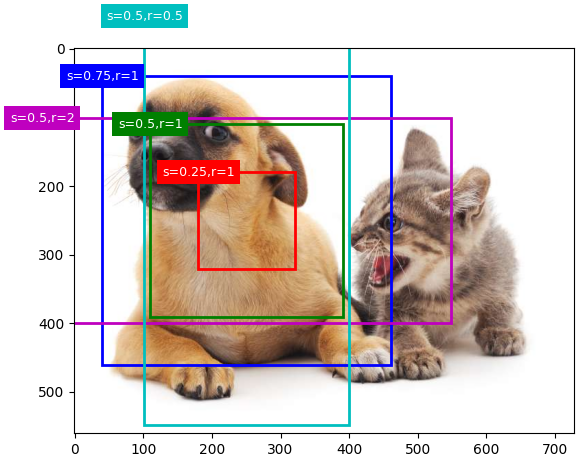

In [38]:
plt.figure(figsize=(8, 5))
bbox_scale = torch.tensor((w, h, w, h), device=boxes.device)
# Convert tensor to numpy array and ensure correct format for imshow
img_np = img.permute(1, 2, 0).numpy()
fig = plt.imshow(img_np)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75,r=1', 's=0.5,r=1', 's=0.25,r=1', 's=0.5,r=2', 's=0.5,r=0.5'])

### Intersection over union (IOU)

In [39]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

Labelling anchor boxes in training data

In [40]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### Labelling the offsets

In [41]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [42]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

## An Example

TypeError: Invalid shape (3, 561, 728) for image data

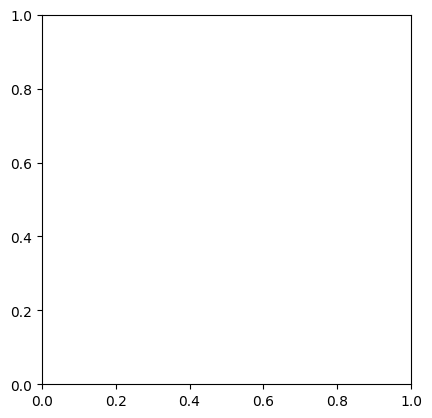

In [43]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [ ]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))